**The Original Notbook used to train and experiment with models (for reference)**
* Imports may not work due to directory change

# **Music Genre Classification**
* Classifying audio files into 10 different music genres based on their features

In [ ]:
# Downloading Dataset
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification --unzip

In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import librosa
import numpy as np
import random
import utils, engine

from pathlib import Path
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchinfo import summary
from torchmetrics import Accuracy, ConfusionMatrix
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from mlxtend.plotting import plot_confusion_matrix

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Creating CSV to save filepaths and lables from the datset

In [4]:
# Getting filepaths and labels from the dataset
data_dir = Path("Data/genres_original")

filepaths = []
labels = []

for genre_dir in data_dir.iterdir():
    if genre_dir.is_dir():
        genre = genre_dir.name

        for file in genre_dir.glob("*.wav"):
            filepaths.append(str(file))
            labels.append(genre)

# Creating Dataframe
df = pd.DataFrame({"FilePath": filepaths,
                   "Class": labels})

# Mapping Gneres to numbers
df["Class"] = df["Class"].astype("category").cat.codes

# Saving to CSV
df.to_csv("dataset.csv", index=False)
class_names = list(set(labels))
print(df.head())

                                     FilePath  Class
0  Data\genres_original\blues\blues.00000.wav      0
1  Data\genres_original\blues\blues.00001.wav      0
2  Data\genres_original\blues\blues.00002.wav      0
3  Data\genres_original\blues\blues.00003.wav      0
4  Data\genres_original\blues\blues.00004.wav      0


In [5]:
# Creating Dataset Class
class custom_dataset(Dataset):
    def __init__(self, dataframe, sr=22050, segment_duration=5, img_height=288, img_width=288, transform=None):
        self.dataframe = dataframe
        self.labels = list(dataframe["Class"])
        self.filepaths = list(dataframe["FilePath"])
        self.sr = sr
        self.segment_duration = segment_duration
        self.img_height = img_height
        self.img_width = img_width
        self.total_duration = 30
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        file_path = self.filepaths[index]
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.long)

        # --- Random 5s segment ---
        max_offset = self.total_duration - self.segment_duration
        offset = random.uniform(0, max_offset)

        signal, sr = librosa.load(file_path, sr=self.sr, offset=offset, duration=self.segment_duration)

        # --- Mel Spectrogram ---
        spec = librosa.feature.melspectrogram(y=signal,
                                            sr=sr,
                                            n_fft=2048,
                                            hop_length=512,
                                            n_mels=self.img_height)
        spec_db = librosa.power_to_db(spec, ref=np.max)

        # --- Resize ---
        spec_resized = resize(spec_db, (self.img_height, self.img_width), anti_aliasing=True)

        # --- Convert to RGB (3-channel) ---
        spec_resized = np.stack([spec_resized] * 3, axis=-1)
        spec_resized = (255 * (spec_resized - spec_resized.min()) / (spec_resized.max() - spec_resized.min())).astype(np.uint8)

        # --- Convert to PIL Image ---
        spec_img = Image.fromarray(spec_resized)

        # --- Apply EfficientNet transforms ---
        if self.transform:
            audio = self.transform(spec_img)
        else:
            audio = transforms.ToTensor()(spec_img)

        return audio, label



### Creating the model and dataloaders

In [6]:
utils.set_seed(42)

model_weights = models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = models.efficientnet_b2(weights=model_weights).to(device)

auto_transforms = model_weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [7]:
# Creating Dataset instance
data_df = pd.read_csv('dataset.csv')

le = LabelEncoder()
data_df["Class"] = le.fit_transform(df["Class"])
audio_dataset = custom_dataset(dataframe=data_df,
                               transform=auto_transforms)

# Train test split
train_size = int(0.8 * len(audio_dataset))
test_size = len(audio_dataset) - train_size

train_data, test_data = random_split(dataset=audio_dataset,
                                     lengths=[train_size, test_size])


In [7]:
len(train_data), len(test_data)

(799, 200)

In [8]:
# Creating Dataloaders
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=0,
                             shuffle=False)

In [9]:
sample = next(iter(train_dataloader))
audio, label = sample
audio, label

(tensor([[[[ 0.0741, -0.0458, -0.5767,  ..., -0.0116,  0.4166,  0.6734],
           [ 0.0741, -0.0801, -0.5082,  ...,  0.1768,  0.4508,  0.7248],
           [ 0.0912, -0.0629, -0.4397,  ...,  0.3823,  0.5536,  0.7933],
           ...,
           [-1.4329, -1.5870, -1.8610,  ..., -2.0665, -1.7925, -1.4843],
           [-1.4329, -1.5870, -1.8610,  ..., -2.0665, -1.7925, -1.4843],
           [-1.4329, -1.5870, -1.8782,  ..., -2.0665, -1.7925, -1.4843]],
 
          [[ 0.2052,  0.0826, -0.4601,  ...,  0.1176,  0.5553,  0.8179],
           [ 0.2052,  0.0476, -0.3901,  ...,  0.3102,  0.5903,  0.8704],
           [ 0.2227,  0.0651, -0.3200,  ...,  0.5203,  0.6954,  0.9405],
           ...,
           [-1.3354, -1.4930, -1.7731,  ..., -1.9832, -1.7031, -1.3880],
           [-1.3354, -1.4930, -1.7731,  ..., -1.9832, -1.7031, -1.3880],
           [-1.3354, -1.4930, -1.7906,  ..., -1.9832, -1.7031, -1.3880]],
 
          [[ 0.4265,  0.3045, -0.2358,  ...,  0.3393,  0.7751,  1.0365],
           [ 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


(np.float64(-0.5), np.float64(287.5), np.float64(287.5), np.float64(-0.5))

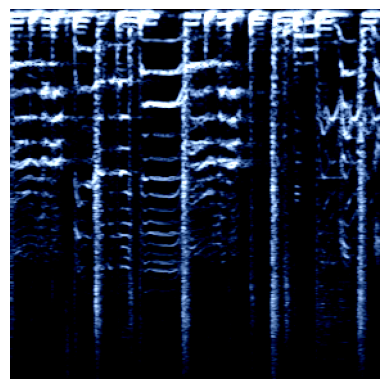

In [10]:
# Visualizing a Spectrogram
audio_sample = audio[1]
plt.imshow(audio_sample.permute(1, 2, 0))
plt.axis(False)

In [11]:
# Freezing Model weights and Modifying classfier layer
for param in effnetb2.parameters():
    param.requires_grad = False

effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features=1408,
              out_features=len(class_names))
)

summary(effnetb2,
        input_size=audio.shape,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 288, 288]    [32, 1408, 9, 9]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 288, 288]    [32, 32, 144, 144]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 288, 288]    [32, 32, 144, 144]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 144, 144]   [32, 32, 144, 144]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 144, 144]   [32, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [32, 32, 144, 144]   [32, 

In [12]:
# Defining loss function, optimizer and accuracy function
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=0.001)
accuracy_fn = Accuracy(task='multiclass',
                       num_classes=len(class_names)).to(device)

In [13]:
# Tarining the Model
utils.set_seed(42)
NUM_EPOCHS = 10

effnetb2_results = engine.train_model(model=effnetb2,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      accuracy_fn=accuracy_fn,
                                      optimizer=optimizer,
                                      epochs=NUM_EPOCHS,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 2.1551 | Train Acc: 25.669% | Test Loss: 2.1231 | Test Acc: 31.696%
Epoch: 2 | Train Loss: 1.8790 | Train Acc: 48.552% | Test Loss: 1.8477 | Test Acc: 49.554%
Epoch: 3 | Train Loss: 1.7271 | Train Acc: 52.310% | Test Loss: 1.6984 | Test Acc: 53.571%
Epoch: 4 | Train Loss: 1.6158 | Train Acc: 54.560% | Test Loss: 1.5637 | Test Acc: 59.821%
Epoch: 5 | Train Loss: 1.5485 | Train Acc: 58.077% | Test Loss: 1.5187 | Test Acc: 62.054%
Epoch: 6 | Train Loss: 1.4915 | Train Acc: 60.331% | Test Loss: 1.4761 | Test Acc: 61.607%
Epoch: 7 | Train Loss: 1.4752 | Train Acc: 62.952% | Test Loss: 1.4267 | Test Acc: 64.732%
Epoch: 8 | Train Loss: 1.4633 | Train Acc: 60.960% | Test Loss: 1.4002 | Test Acc: 62.500%
Epoch: 9 | Train Loss: 1.4272 | Train Acc: 61.960% | Test Loss: 1.3957 | Test Acc: 64.286%
Epoch: 10 | Train Loss: 1.3961 | Train Acc: 65.698% | Test Loss: 1.4047 | Test Acc: 64.732%


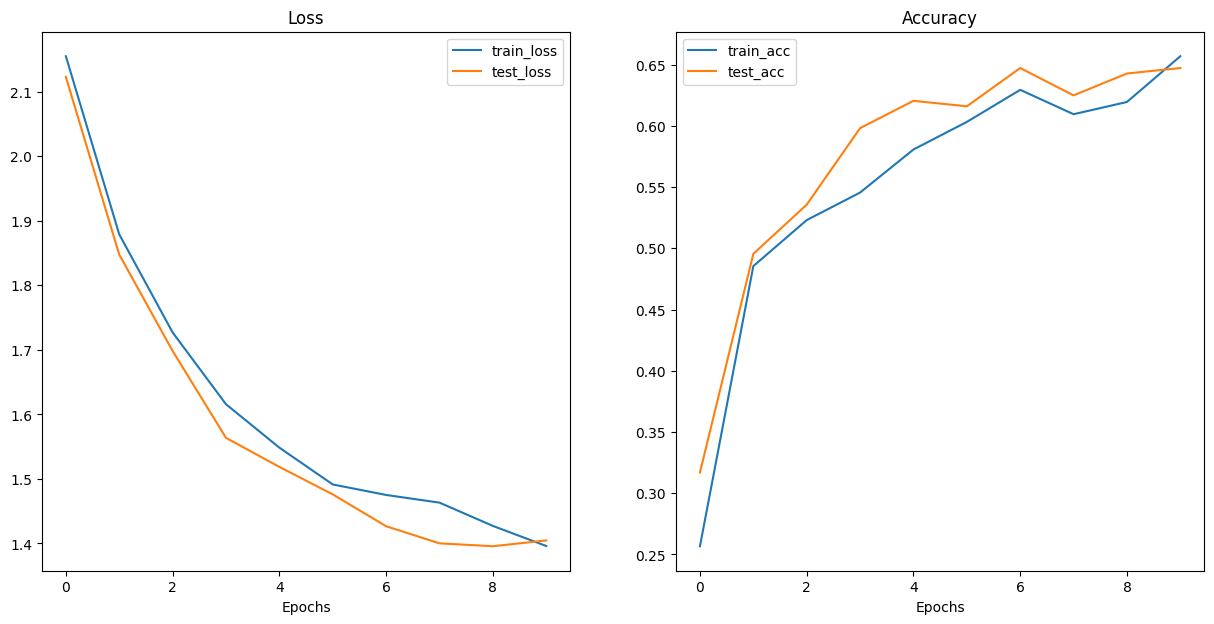

In [14]:
effnetb2_results_cpu = {
    k: [float(v.cpu()) for v in vals] for k, vals in effnetb2_results.items()
}

utils.plot_loss_curves(results=effnetb2_results_cpu)

### **Trying `ResNet-50`**

In [15]:
utils.set_seed(42)

resnet_weights = models.ResNet50_Weights.DEFAULT
resnet50 = models.resnet50(weights=resnet_weights).to(device)

resnet_transforms = resnet_weights.transforms()

# Freezing all layers but last one
for name, param in resnet50.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

    else:
        param.requires_grad = False

resnet50.fc = nn.Linear(in_features=2048,
                        out_features=len(class_names))




In [16]:
summary(resnet50, input_size=audio.shape,
        col_names=['input_size', 'output_size', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Trainable
ResNet (ResNet)                          [32, 3, 288, 288]    [32, 10]             Partial
├─Conv2d (conv1)                         [32, 3, 288, 288]    [32, 64, 144, 144]   False
├─BatchNorm2d (bn1)                      [32, 64, 144, 144]   [32, 64, 144, 144]   False
├─ReLU (relu)                            [32, 64, 144, 144]   [32, 64, 144, 144]   --
├─MaxPool2d (maxpool)                    [32, 64, 144, 144]   [32, 64, 72, 72]     --
├─Sequential (layer1)                    [32, 64, 72, 72]     [32, 256, 72, 72]    False
│    └─Bottleneck (0)                    [32, 64, 72, 72]     [32, 256, 72, 72]    False
│    │    └─Conv2d (conv1)               [32, 64, 72, 72]     [32, 64, 72, 72]     False
│    │    └─BatchNorm2d (bn1)            [32, 64, 72, 72]     [32, 64, 72, 72]     False
│    │    └─ReLU (relu)                  [32, 64, 72, 72]     [32, 64, 72, 72]     --
│    │    └─Conv2d (conv

In [17]:
resnet_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [18]:
# Creating dataset with appropriate transforms
resnet_dataset = custom_dataset(data_df,
                                transform=resnet_transforms)

resnet_train_data, resnet_test_data = random_split(dataset=resnet_dataset,
                                 lengths=[train_size, test_size])

BATCH_SIZE = 32
resnet_train_dataloader  = DataLoader(dataset=resnet_train_data,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      num_workers=0)

resnet_test_dataloader = DataLoader(dataset=resnet_test_data,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=0)

In [19]:
sample = next(iter(train_dataloader))
audio, label = sample
audio, label

(tensor([[[[ 0.6734,  0.5193,  0.2111,  ..., -0.5767, -0.3369, -0.1143],
           [ 0.7591,  0.7419,  0.6734,  ..., -0.1657,  0.0056,  0.1254],
           [ 0.6906,  0.9132,  1.0844,  ..., -0.2342, -0.0801,  0.1083],
           ...,
           [-1.4329, -1.3644, -1.4158,  ..., -1.4500, -1.7412, -1.8439],
           [-1.5870, -1.5185, -1.5185,  ..., -1.3815, -1.5528, -1.6384],
           [-1.4843, -1.3987, -1.3815,  ..., -1.4843, -1.5870, -1.6555]],
 
          [[ 0.8179,  0.6604,  0.3452,  ..., -0.4601, -0.2150,  0.0126],
           [ 0.9055,  0.8880,  0.8179,  ..., -0.0399,  0.1352,  0.2577],
           [ 0.8354,  1.0630,  1.2381,  ..., -0.1099,  0.0476,  0.2402],
           ...,
           [-1.3354, -1.2654, -1.3179,  ..., -1.3529, -1.6506, -1.7556],
           [-1.4930, -1.4230, -1.4230,  ..., -1.2829, -1.4580, -1.5455],
           [-1.3880, -1.3004, -1.2829,  ..., -1.3880, -1.4930, -1.5630]],
 
          [[ 1.0365,  0.8797,  0.5659,  ..., -0.2358,  0.0082,  0.2348],
           [ 

In [20]:
# Loss function and optimizer
resnet_loss_fn = nn.CrossEntropyLoss()
resenet_optimizer = torch.optim.Adam(params=resnet50.parameters(),
                                     lr=0.001)

In [21]:
# Training the model
utils.set_seed(42)

NUM_EPOCHS = 15
resnet50_results = engine.train_model(model=resnet50,
                                      train_dataloader=resnet_train_dataloader,
                                      test_dataloader=resnet_test_dataloader,
                                      loss_fn=resnet_loss_fn,
                                      optimizer=resenet_optimizer,
                                      accuracy_fn=accuracy_fn,
                                      epochs=NUM_EPOCHS)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.7197 | Train Acc: 41.573% | Test Loss: 2.0250 | Test Acc: 38.393%
Epoch: 2 | Train Loss: 1.0180 | Train Acc: 63.956% | Test Loss: 2.8657 | Test Acc: 37.500%
Epoch: 3 | Train Loss: 0.7800 | Train Acc: 73.976% | Test Loss: 1.1453 | Test Acc: 62.946%
Epoch: 4 | Train Loss: 0.6656 | Train Acc: 77.980% | Test Loss: 1.0405 | Test Acc: 64.286%
Epoch: 5 | Train Loss: 0.5973 | Train Acc: 78.960% | Test Loss: 1.1091 | Test Acc: 65.179%
Epoch: 6 | Train Loss: 0.4818 | Train Acc: 84.367% | Test Loss: 0.8443 | Test Acc: 75.446%
Epoch: 7 | Train Loss: 0.4477 | Train Acc: 84.722% | Test Loss: 0.9390 | Test Acc: 73.214%
Epoch: 8 | Train Loss: 0.4504 | Train Acc: 85.718% | Test Loss: 0.9861 | Test Acc: 73.661%
Epoch: 9 | Train Loss: 0.4225 | Train Acc: 86.238% | Test Loss: 0.8972 | Test Acc: 73.661%
Epoch: 10 | Train Loss: 0.3659 | Train Acc: 87.859% | Test Loss: 1.0092 | Test Acc: 77.232%
Epoch: 11 | Train Loss: 0.3492 | Train Acc: 88.363% | Test Loss: 0.9470 | Test Acc: 72.32

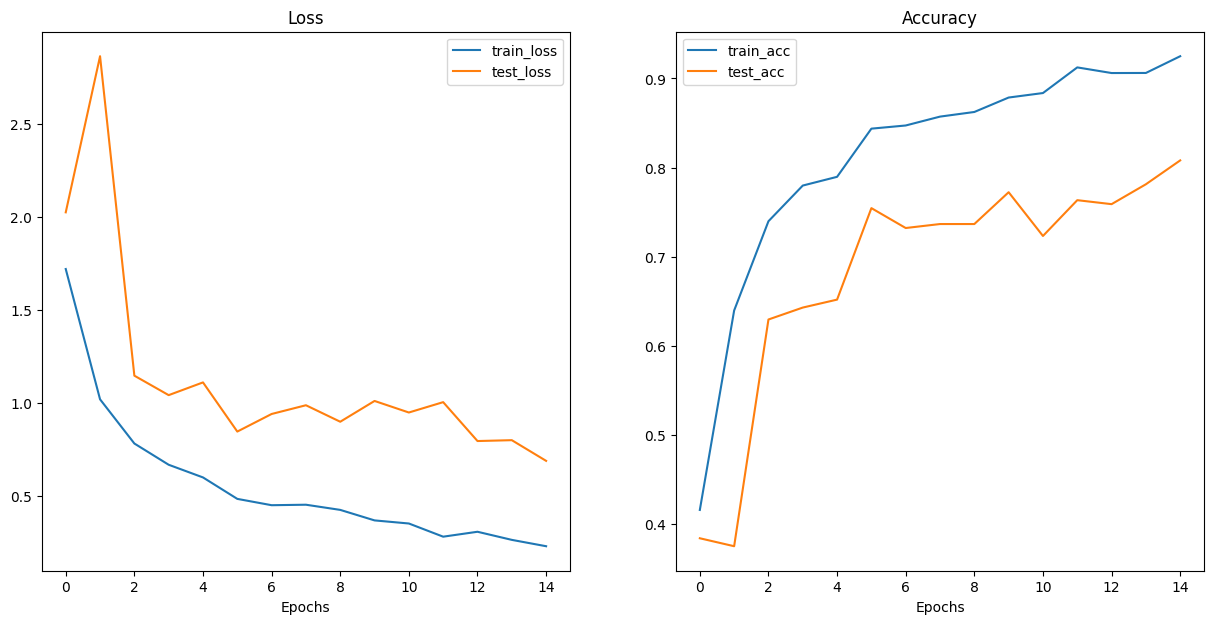

In [22]:
resnet50_results_cpu = {
    k: [float(v.cpu()) for v in vals] for k, vals in resnet50_results.items()
}

utils.plot_loss_curves(resnet50_results_cpu)

In [23]:
# # Saving the model
# save_dir = Path('saved_modes/')
# utils.save_model(model=resnet50,
#                  target_dir=save_dir,
#                  model_name='music_gnere_resnet50_15_epochs.pth')

In [30]:
save_dir = Path('saved_modes/')

### **Trying resnet34**

In [24]:
utils.set_seed(42)

resnet34_weights = models.ResNet34_Weights.DEFAULT
resnet34 = models.resnet34(weights=resnet34_weights).to(device)

# Freezing all layers but last one
for name, param in resnet34.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

resnet34.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512,
              out_features=len(class_names))
)

summary(model=resnet34,
        input_size=audio.shape,
        col_names=['input_size', 'output_size', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Trainable
ResNet (ResNet)                          [32, 3, 288, 288]    [32, 10]             Partial
├─Conv2d (conv1)                         [32, 3, 288, 288]    [32, 64, 144, 144]   False
├─BatchNorm2d (bn1)                      [32, 64, 144, 144]   [32, 64, 144, 144]   False
├─ReLU (relu)                            [32, 64, 144, 144]   [32, 64, 144, 144]   --
├─MaxPool2d (maxpool)                    [32, 64, 144, 144]   [32, 64, 72, 72]     --
├─Sequential (layer1)                    [32, 64, 72, 72]     [32, 64, 72, 72]     False
│    └─BasicBlock (0)                    [32, 64, 72, 72]     [32, 64, 72, 72]     False
│    │    └─Conv2d (conv1)               [32, 64, 72, 72]     [32, 64, 72, 72]     False
│    │    └─BatchNorm2d (bn1)            [32, 64, 72, 72]     [32, 64, 72, 72]     False
│    │    └─ReLU (relu)                  [32, 64, 72, 72]     [32, 64, 72, 72]     --
│    │    └─Conv2d (conv

In [33]:
resnet34_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
resenet34_optimizer = torch.optim.AdamW(params=resnet34.parameters(),
                                       lr=1e-4,
                                       weight_decay=1e-4)
resnet34_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=resenet34_optimizer,
                                                                mode='min',
                                                                factor=0.5,
                                                                patience=2)

In [26]:
utils.set_seed(42)
NUM_EPOCHS = 15

resnet34_results = engine.train_model(model=resnet34,
                                      train_dataloader=resnet_train_dataloader,
                                      test_dataloader=resnet_test_dataloader,
                                      loss_fn=resnet_loss_fn,
                                      optimizer=resenet34_optimizer,
                                      accuracy_fn=accuracy_fn,
                                      epochs=NUM_EPOCHS,
                                      scheduler_fn=resnet34_scheduler,
                                      device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.9901 | Train Acc: 33.306% | Test Loss: 1.6711 | Test Acc: 45.536%
Epoch: 2 | Train Loss: 1.1047 | Train Acc: 63.093% | Test Loss: 1.1588 | Test Acc: 61.607%
Epoch: 3 | Train Loss: 0.8493 | Train Acc: 72.706% | Test Loss: 0.8786 | Test Acc: 71.429%
Epoch: 4 | Train Loss: 0.6584 | Train Acc: 78.855% | Test Loss: 0.7849 | Test Acc: 74.107%
Epoch: 5 | Train Loss: 0.5885 | Train Acc: 80.972% | Test Loss: 0.6932 | Test Acc: 79.911%
Epoch: 6 | Train Loss: 0.4833 | Train Acc: 83.238% | Test Loss: 0.7471 | Test Acc: 76.786%
Epoch: 7 | Train Loss: 0.4459 | Train Acc: 86.488% | Test Loss: 0.6421 | Test Acc: 82.143%
Epoch: 8 | Train Loss: 0.4166 | Train Acc: 86.859% | Test Loss: 0.9936 | Test Acc: 73.214%
Epoch: 9 | Train Loss: 0.3544 | Train Acc: 88.242% | Test Loss: 0.6959 | Test Acc: 79.018%
Epoch: 10 | Train Loss: 0.3091 | Train Acc: 89.859% | Test Loss: 0.7293 | Test Acc: 78.125%
Epoch: 11 | Train Loss: 0.2744 | Train Acc: 92.250% | Test Loss: 0.8361 | Test Acc: 75.00

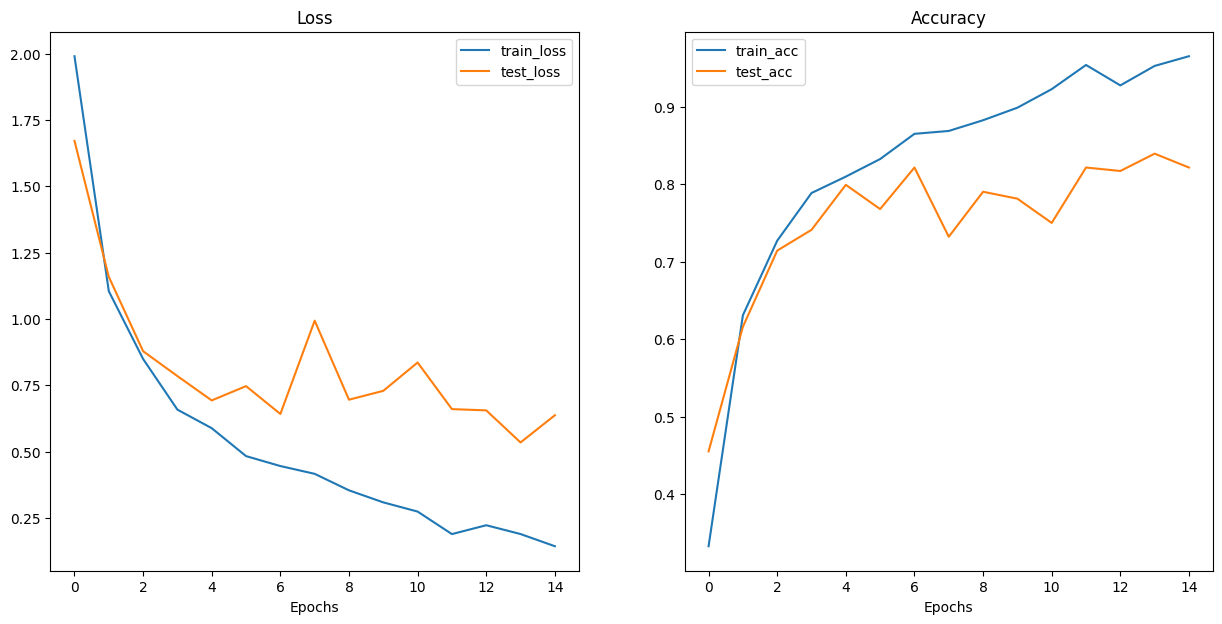

In [27]:
resnet34_results_cpu = {
    k: [float(v.cpu()) for v in vals] for k, vals in resnet34_results.items()
}

utils.plot_loss_curves(resnet34_results_cpu)

In [28]:
# utils.save_model(model=resnet34,
#                  target_dir=save_dir,
#                  model_name="music_gnere_resnet34_15_epochs.pth")

#### Using the best model to plot confusion matrix

In [32]:
# Loading the state_dict
resnet34.load_state_dict(torch.load(f=save_dir / "music_gnere_resnet34_15_epochs.pth"))

<All keys matched successfully>

In [ ]:
# Evaluating 

eval_loss, eval_acc = engine.test_step(model=resnet34,
                                       dataloader=resnet_test_dataloader,
                                       loss_fn=resnet34_loss_fn,
                                       accuracy_fn=accuracy_fn,
                                       device=device)
eval_loss, eval_acc

(tensor(1.1991, device='cuda:0'), tensor(0.8438, device='cuda:0'))

In [49]:
# Making predictions on test dataset
eval_preds = []
target_labels = []
resnet34.eval()
with(torch.inference_mode()):
    for X, y in resnet_test_dataloader:
        X, y = X.to(device), y.to(device)

        eval_logits = resnet34(X)
        eval_pred = torch.softmax(eval_logits, dim=0).argmax(dim=1)
        eval_preds.append(eval_pred.cpu())
        target_labels.append(y.cpu())

    # Creating a single tensor
    eval_preds_tensor = torch.cat(eval_preds)
    target_labels_tensor = torch.cat(target_labels)
    print(eval_preds_tensor[:10])

tensor([4, 5, 8, 9, 8, 9, 6, 8, 3, 7])


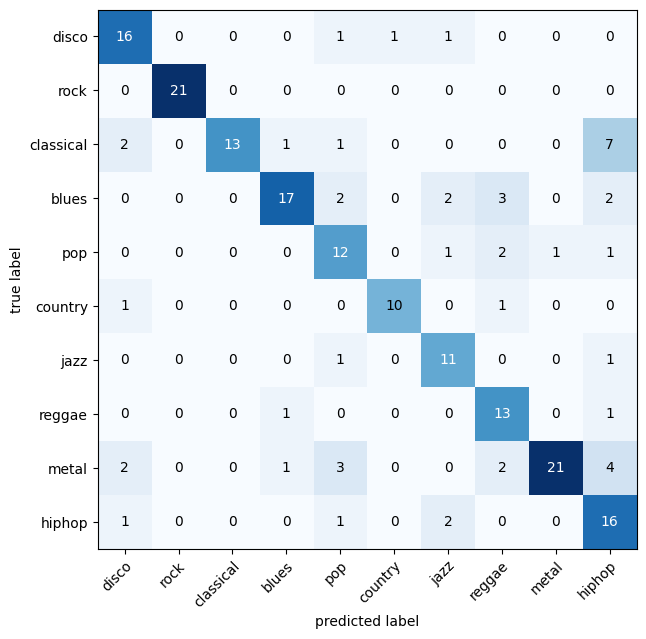

In [50]:
# Plotting Confusion Matrix
confmat = ConfusionMatrix(task='multiclass',
                          num_classes=len(class_names))
confmat_tensor = confmat(preds=eval_preds_tensor,
                         target=target_labels_tensor)

# Plotting 
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10, 7))